In [ ]:
import cv2
import glob
import numpy as np
from math import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

In [ ]:
def calibrate_camera(images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

cal_images = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)

In [3]:
def sobel(gray, orient='x', sobel_kernel=3):
    return cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    retval, output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)

    retval, output = cv2.threshold(mag_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = (np.absolute(np.arctan(sobely/sobelx)))
        dir_binary =  np.zeros_like(absgraddir, dtype=np.uint8)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return dir_binary

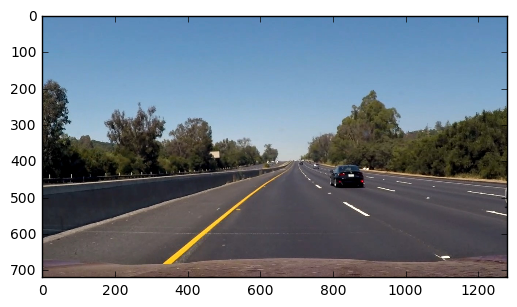

In [4]:
image = mpimage.imread('test_images/test1c.jpg')
# plt.imshow(hls[:,:,2], cmap='gray')
plt.imshow(image)
# plt.figure()
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.show()

In [5]:
def find_edges(image, ksize = 15):
#     plt.imshow(image)
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
    
    s = hls[:,:,2]
    h = hls[:,:,0]

    sobelx = sobel(gray, orient='x', sobel_kernel=ksize)
    gradx = abs_sobel_thresh(sobelx, thresh=(60, 70))

    sobely = sobel(gray, orient='y', sobel_kernel=ksize)
    grady = abs_sobel_thresh(sobely, thresh=(90, 150))
    mag_binary = mag_thresh(sobelx, sobely, thresh=(50, 100))
    # dir_binary = dir_threshold(sobelx, sobely, thresh=(0.7, 1.3))

    _, s_binary = cv2.threshold(s.astype('uint8'), 170, 255, cv2.THRESH_BINARY)
    _, h_binary = cv2.threshold(h.astype('uint8'), 0, 10, cv2.THRESH_BINARY)

    color_binary = np.dstack(( mag_binary, h_binary, s_binary))#, h_binary))
#     plt.imshow(color_binary)
#     plt.show()
#     return mag_binary
    combined_binary = np.clip(cv2.bitwise_or(s_binary, mag_binary), 0, 1).astype('uint8')
    return combined_binary

In [ ]:
undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

edges = find_edges(undist)
plt.imshow(edges, cmap='gray')
plt.show()

In [6]:
def get_perspective_transform(image):
    img_size = image.shape
    src = np.array([[565. /1280.*img_size[1], 455./720.*img_size[0]],
                    [725. /1280.*img_size[1], 455./720.*img_size[0]],
                    [1130./1280.*img_size[1], 720./720.*img_size[0]],
                    [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

    dst = np.array([[300. /1280.*img_size[1], 0.  /720.*img_size[0]],
                    [1000./1280.*img_size[1], 0.  /720.*img_size[0]],
                    [1000./1280.*img_size[1], 720./720.*img_size[0]],
                    [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)
    return warp_m, warp_minv

In [ ]:
warp_m, warp_minv = get_perspective_transform(edges)
lanes = cv2.warpPerspective(edges, warp_m, (edges.shape[1], edges.shape[0]), flags=cv2.INTER_LINEAR)
plt.rcParams['figure.figsize'] = figsize=(10,12)

plt.figure(figsize=(10,12))
plt.subplot(1, 2, 1)
plt.imshow(undist)

plt.subplot(1, 2, 2)
plt.imshow(lanes, cmap='gray')

plt.show()

In [ ]:
histogram = np.sum(lanes[int(lanes.shape[0]*0.50):,:], axis=0)
plt.figure(figsize=(5,5))
plt.plot(histogram)

In [7]:
from scipy.signal import find_peaks_cwt

def find_base_points(lanes):
    """Uses histogram to find possible base points for lane lines"""
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)
    idx = find_peaks_cwt(hist, [100], max_distances=[100]) 
    if len(idx) < 2:
        return None
    middle = np.average(idx)
    left_pt = max(i for i in idx if i < middle)   # Closest peak to middle on the left
    right_pt = min(i for i in idx if i >= middle) # Closest peak to middle on the right
    return [left_pt, right_pt]

In [ ]:
base_pts = find_base_points(lanes)
print(base_pts)

In [8]:
# Sliding window to detect left and right 
def find_lane_points(lanes, base_pts, num_bands = 25, window_width = 0.05):
    height = lanes.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(window_width*lanes.shape[1])
    
    l_x, l_y, r_x, r_y = [], [], [], []
    
    base_left, base_right = base_pts
    idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = lanes[i*band_height:(i+1)*band_height,base_left-band_width//2:base_left+band_width//2]
        w_right = lanes[i*band_height:(i+1)*band_height,base_right-band_width//2:base_right+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + base_left-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ base_right-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left-band_width//2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right-band_width//2
    
    return l_x, l_y, r_x, r_y

In [ ]:
l_x, l_y, r_x, r_y = find_lane_points(lanes, base_pts)

if len(l_x) > 0 and len(r_x) > 0:
    p_left = np.polyfit(l_y, l_x, 2)
    p_right = np.polyfit(r_y, r_x, 2)

p_left, p_right = find_lane_curve(lanes, base_pts)

In [ ]:
plt.imshow(lanes, cmap='gray')
yvals = np.linspace(0, image.shape[0],101)
left_fitx = p_left[0]*yvals**2 + p_left[1]*yvals + p_left[2]
right_fitx = p_right[0]*yvals**2 + p_right[1]*yvals + p_right[2]

plt.plot(left_fitx, yvals)
plt.plot(right_fitx, yvals)
plt.show()

In [9]:
def draw_lanes(image, p_left, p_right, warp_minv):
    """Function to draw lanes on the image"""
    yvals = np.linspace(0, image.shape[0],101)
    left_fitx = p_left[0]*yvals**2 + p_left[1]*yvals + p_left[2]
    right_fitx = p_right[0]*yvals**2 + p_right[1]*yvals + p_right[2]
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warp_minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [ ]:
A, B, _ = p_left
y = image.shape[0]
R_left = (1 + (2*A*y + B)**2)**(3/2) / abs(2*A)
# print(R_left)

In [ ]:
result = draw_lanes(image, p_left, p_right, warp_minv)
plt.imshow(result)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
import collections

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist

cam_mtx, cam_dist = camera_setup()

In [11]:
# Define a class to receive the characteristics of each line detection
import collections
from itertools import chain, repeat
    
class Lane():
    def __init__(self, base_pt, img_size):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=10)
        self.recent_yfitted = collections.deque(maxlen=10)
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.current_xfit = None
        self.roi_mask = None
        
        self.img_size = img_size
        self.base_pt = base_pt
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
    
    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        x_hist = list(chain(*self.recent_xfitted, x))
        y_hist = list(chain(*self.recent_yfitted, y))

        p_lane = np.polyfit(y_hist, x_hist, 2)

        x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
        
        self.current_xfit = x_fit
        
        # Save current detected pixels
        self.allx = np.array(x)
        self.ally = np.array(y)

        self.recent_xfitted.append(x_fit)
        self.recent_yfitted.append(self.yvals)
        if len(self.current_fit) > 1:
            self.diffs = self.current_fit - p_lane

        self.current_fit = p_lane
        
        # TODO: Add sanity check for fit
        
        # Update ROI mask
        self.mask.fill(0)
        # http://stackoverflow.com/a/35902430/538379 
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255,255,255), thickness=150)
        
        self.detected = True
    
    def detect_from_mask(self, lanes):
        mask_lanes = cv2.bitwise_and(lanes, self.mask)
        y_pts, x_pts = np.nonzero(mask_lanes)
        self.add_lane_pixels(x_pts, y_pts)
        
    def draw_lane(self, image):
        """
        Draws lane on given image
        """
        pts = np.array([np.transpose(np.vstack([self.current_xfit, self.yvals]))])
        cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
        return image
    
def histogram_lane_detection(lanes, base_pts, num_bands = 25, window_width = 0.05):
    """Uses histogram and sliding window to detect lanes from scratch"""

    height = lanes.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(window_width*lanes.shape[1])
    
    l_x, l_y, r_x, r_y = [], [], [], []
    
    base_left, base_right = base_pts
    idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = lanes[i*band_height:(i+1)*band_height,base_left-band_width//2:base_left+band_width//2]
        w_right = lanes[i*band_height:(i+1)*band_height,base_right-band_width//2:base_right+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + base_left-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ base_right-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left-band_width//2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right-band_width//2
    
    left_lane = Lane(base_left, lanes.shape)
    right_lane = Lane(base_right, lanes.shape)
    
    left_lane.add_lane_pixels(l_x, l_y)
    right_lane.add_lane_pixels(r_x, r_y)
    return left_lane, right_lane

In [12]:
def process_image(image, key_frame_interval=2, cache_length=16):
    global cam_mtx, cam_dist
        
    if process_image.cache is None:
        warp_m, warp_minv = get_perspective_transform(image)
                
        cache = {'cam_mtx': cam_mtx,
                 'cam_dist': cam_dist,
                 'warp_m': warp_m,
                 'warp_minv': warp_minv,
                 'last_p_left': collections.deque(maxlen=cache_length),
                 'last_p_right': collections.deque(maxlen=cache_length),
                 'frame_ctr': 0,
                 'left': None,
                 'right': None,
                 'base_pts': None}
    else:
        cache = process_image.cache
    
    
    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    edges = find_edges(undist)
    lanes = cv2.warpPerspective(edges, cache['warp_m'], (edges.shape[1], edges.shape[0]), flags=cv2.INTER_LINEAR)
    
    base_pts = cache['base_pts']
    if cache['frame_ctr'] % key_frame_interval == 0:
        new_base_pts = find_base_points(lanes)
        
        if new_base_pts is not None:
            base_pts = new_base_pts
        else:
            # Could not find new base points
            if base_pts is None: # And no cache exists
                return undist
            else:
                # Re-use previous data if base points could not be found
                cache['frame_ctr'] = cache['frame_ctr'] - 1 # Make sure we try again in the next frame
    
    
    if (left_lane is None or not left_lane.detected) or (right_lane is None or not right_lane.detected):
        # Detect from scratch
        left_lane, right_lane = histogram_lane_detection(lanes, base_pts)
    else:
        left_lane.detect_from_mask(lanes)
        right_lane.detect_from_mask(lanes)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    cache['base_pts'] = base_pts
    process_image.cache = cache
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    yvals = left_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
#     lane1_pts = np.int_([np.transpose(np.vstack([cache['left'].allx, cache['left'].ally]))])
#     lane2_pts = np.int_([np.transpose(np.vstack([cache['right'].allx, cache['right'].ally]))])
#     cv2.fillPoly(color_warp, np.int_([lane1_pts]), (255,0,0))
#     cv2.fillPoly(color_warp, np.int_([lane2_pts]), (255,0,0))
    
#     color_warp[cache['left'].ally, cache['left'].allx,:] = (255,0,0)
#     color_warp[cache['right'].ally, cache['right'].allx,:] = (0,0,255)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, cache['warp_minv'], (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
#     plt.imshow(lanes, cmap='gray')
#     plt.plot(left_fitx, yvals)
#     plt.plot(right_fitx, yvals)
#     plt.plot(cache['left'].allx, cache['left'].ally)
#     plt.plot(cache['right'].allx, cache['right'].ally)
#     plt.show()
    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    process_image.cache = None
    
process_image.clear_cache = clear_cache
clear_cache()
# %time process_image(image)
# %time process_image(image)
# out = process_image(image)
# plt.imshow(out)
# plt.show()

In [18]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')

In [19]:
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [11:13<00:00,  2.52it/s]    | 1/1261 [00:00<06:20,  3.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 10min 33s, sys: 1min 44s, total: 12min 17s
Wall time: 11min 16s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [15]:
clear_cache()
vid_output = 'challenge_video_out.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
vid_clip = clip2.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [03:55<00:00,  1.95it/s]     | 1/485 [00:00<02:23,  3.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 3min 46s, sys: 37.2 s, total: 4min 23s
Wall time: 3min 59s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))